# Concrete categories and functors in DisCoPy

We show how to implement functors from Diagram to concrete categories such as monoid and tensor and how these correspond to weighted context-free grammars and tensor network models respectively. 

## Monoid
Weighted CFGs as functors in the Monoid delooping.

In [1]:
from discopy import monoidal
from discopy.monoidal import Ty
from functools import reduce
import operator

prod = lambda x: reduce(operator.mul, x, 1)

class Monoid(monoidal.Box):
    def __init__(self, m):
        self.m = m
        super().__init__(m, Ty(), Ty())

    def __repr__(self):
        return "Monoid({})".format(self.m)

    def then(self, other):
        if not isinstance(other, Monoid):
            raise ValueError
        return Monoid(self.m * other.m)

    def tensor(self, other):
        return Monoid(self.m * other.m)

    def __call__(self, *others):
        return Monoid(prod([self.m] + [other.m for other in others]))

    @staticmethod
    def id(x):
        if x != Ty():
            raise ValueError
        return Monoid(1)

assert Monoid(2) @ Monoid.id(Ty()) >> Monoid(5) @ Monoid(0.1) == Monoid(1.0)
assert Monoid(2)(Monoid(1), Monoid(4)) == Monoid(8)

A weighted CFG is a monoidal Functor from trees to Monoid.

In [2]:
from discopy.monoidal import Functor, Box, Id

class WeightedGrammar(Functor):
    def __init__(self, ar):
        ob = lambda x: Ty()
        super().__init__(ob, ar, ar_factory=Monoid)

weight = lambda box: Monoid(0.5)\
    if (box.dom, box.cod) == (Ty('N'), Ty('A', 'N')) else Monoid(1.0)

WCFG = WeightedGrammar(weight)
A = Box('A', Ty('N'), Ty('A', 'N'))
tree = A >> Id(Ty('A')) @ A
assert WCFG(tree) == Monoid(0.25)

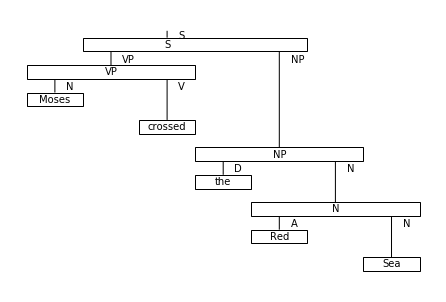

In [3]:
from discopy.operad import from_nltk, tree2diagram
from nltk import CFG
from nltk.parse import RecursiveDescentParser
grammar = CFG.fromstring("""
S -> VP NP
NP -> D N
VP -> N V
N -> A N
V -> 'crossed'
D -> 'the'
N -> 'Moses'
A -> 'Red'
N -> 'Sea'""")

rd = RecursiveDescentParser(grammar)
parse = next(rd.parse('Moses crossed the Red Sea'.split()))
diagram = tree2diagram(from_nltk(parse))
parse2 = next(rd.parse('Moses crossed the Red Red Sea'.split()))
diagram2 = tree2diagram(from_nltk(parse2))
assert WCFG(diagram).m > WCFG(diagram2).m
diagram.draw()

## Tensor

Implementation of the category of tensors with matrix multiplication as 'then' and kronecker product as 'tensor'.

We check the axioms of compact-closed categories for a given object.

In [19]:
from discopy import Dim, Tensor
import numpy as np

x = Dim(3, 2)
cup_r, cap_r = Tensor.cups(x, x.r), Tensor.caps(x.r, x)
cup_l, cap_l = Tensor.cups(x.l, x), Tensor.caps(x, x.l)
snake_r = Tensor.id(x) @ cap_r >> cup_r @ Tensor.id(x)
snake_l =  cap_l @ Tensor.id(x) >> Tensor.id(x) @ cup_l
assert np.allclose(snake_l.array, Tensor.id(x).array, snake_r.array)

swap = Tensor.swap(x, x)
assert np.allclose((swap >> swap).array, Tensor.id(x @ x).array)
assert np.allclose((swap @ Tensor.id(x) >> Tensor.id(x) @ swap).array, Tensor.swap(x, x @ x).array)

We generate a pregroup reduction with Lambeq and evaluate it in a tensor model.

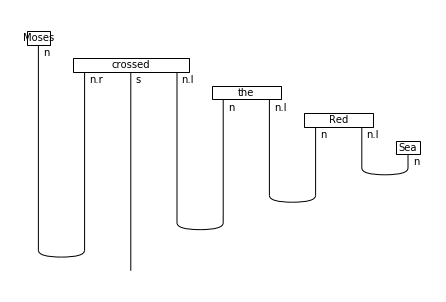

In [5]:
from discopy.rigid import Ty, Id, Box, Cup

n, s = Ty('n'), Ty('s')
Moses, Sea = Box('Moses', Ty(), n), Box('Sea', Ty(), n)
Red, the = Box('Red', Ty(), n @ n.l), Box('the', Ty(), n @ n.l)
crossed = Box('crossed', Ty(), n.r @ s @ n.l)

# Diagram for 'Moses crossed the Red Sea' generated with lambeq's BobcatParser:
diagram = Moses >> Id(n) @ crossed >> Id(n @ n.r @ s @ n.l) @ the >> Id(n @ n.r @ s @ n.l @ n @ n.l) @ Red >> Id(n @ n.r @ s @ n.l @ n @ n.l @ n @ n.l) @ Sea >> Id(n @ n.r @ s @ n.l @ n @ n.l @ n) @ Cup(n.l, n) >> Id(n @ n.r @ s @ n.l @ n) @ Cup(n.l, n) >> Id(n @ n.r @ s) @ Cup(n.l, n) >> Cup(n, n.r) @ Id(s)
diagram.draw()

In [6]:
from discopy.tensor import Dim, Tensor, Functor
import numpy as np

def box_to_array(box):
    if box.name =='Moses':
        return np.array([1, 0])
    if box.name == 'Sea':
        return np.array([0, 1])
    if box.name == 'crossed':
        return np.array([[0, 1], [1, 0]])
    if box.name in ['the', 'Red']:
        return np.eye(2)
    else:
        raise NotImplementedError()

ob = lambda x: 2 if x == n else 1
F = Functor(ob, box_to_array)
F(diagram)

Tensor(dom=Dim(1), cod=Dim(1), array=[1.])

## Function
Implementation of the category of Python functions with cartesian product as tensor.
Application: towards Montague moodels.

In [7]:
class Function(monoidal.Box):
    def __init__(self, inside, dom, cod):
        self.inside = inside
        name = "Function({}, {}, {})".format(inside, dom, cod)
        super().__init__(name, dom, cod)

    def then(self, other):
        inside = lambda *xs: other(*tuple(self(*xs)))
        return Function(inside, self.dom, other.cod)

    def tensor(self, other):
        def inside(*xs):
            left, right = xs[:len(self.dom)], xs[len(self.dom):]
            result = tuple(self(*left)) + tuple(other(*right))
            return (result[0], ) if len(self.cod @ other.cod) == 1 else result
        return Function(inside, self.dom @ other.dom, self.cod @ other.cod)

    def __call__(self, *xs): return self.inside(*xs)

    @staticmethod
    def id(x):
        return Function(lambda *xs: xs, x, x)

    @staticmethod
    def copy(x):
        return Function(lambda *xs: (*xs, *xs), x, x @ x)
    
    @staticmethod
    def delete(x):
        return Function(lambda *xs: (), x, Ty())
    
    @staticmethod
    def swap(x, y):
        return Function(lambda x0, y0: (y0, x0), x @ y, y @ x)
    
    @staticmethod
    def dagger(self):
        return self

We check the axioms of cartesian categories

In [9]:
X = Ty('X')
copy = Function.copy(X)
delete = Function.delete(X)
I = Function.id(X)
swap = Function.swap(X, X)

assert (copy >> copy @ I)(54) == (copy >> I @ copy)(54)
assert (copy >> delete @ I)(46) == (copy >> I @ delete)(46)
assert (copy >> swap)('was my number') == (copy)('was my number')

f = Function(lambda x: (46,) if x == 54 else (54,), X, X)
assert (f >> copy)(54) == (copy >> f @ f)(54)
assert (copy @ copy >> I @ swap @ I)(54, 46) == Function.copy(X @ X)(54, 46)

We generate a diagram using the interface with SpaCy... 

In [10]:
from discopy.operad import from_spacy, tree2diagram
import spacy
nlp = spacy.load("en_core_web_sm") 
doc = nlp("Fifty four was my number")

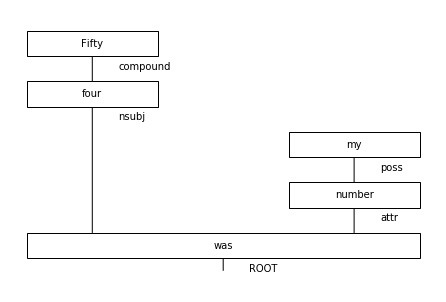

In [11]:
diagram = tree2diagram(from_spacy(doc), contravariant=True)
diagram.draw()

... and we evaluate its semantics as Functor to Function

In [12]:
from discopy.monoidal import Ty, Id, Box, Functor

X = Ty('X')
ob = lambda x: X
def box_to_function(box):
    if box.name == 'was':
        return Function(lambda x, y: (x == y, ), X @ X, X)
    if box.name == 'number':
        return Function.id(X)
    if box.name == 'four':
        return Function(lambda x: (4 + x, ), X, X)
    if box.name == 'Fifty':
        return Function(lambda: (50, ), Ty(), X)
    if box.name == 'my':
        return Function(lambda: (54, ), Ty(), X)
    raise NotImplementedError()

F = Functor(ob, box_to_function, ob_factory=Ty, ar_factory=Function)
F(diagram)()

(True,)

In [21]:
import spacy
nlp = spacy.load("en_core_web_sm")
doc = nlp("Moses crossed the Red Sea")
print(from_spacy(doc))

crossed(Moses, Sea(the, Red))
